# Regression models

In this tutorial we will go over 
* Linear regression using least squares. This is solved analytically, so no learning involved.
* Nonlinear regression from real world examples from the USGS methodology for estimating streamflow return periods in region specific environments.
* Random Forest regression attempting to build a general model that estimate streamflow return periods across CONUS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
#from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

from pylab import cm
from matplotlib import colors as mcol

from netCDF4 import Dataset as NetCDFFile

## Linear regression using least squares
The method of least squares is a standard approach to **approximate** the regression of some input data to some target data.


In [2]:
def least_squares_regression_examples(x,y):
    # Create the design matrix by adding a column of ones to the independent variable
    X = np.column_stack((np.ones_like(x), x))

    # Calculate the coefficients using the least squares formula
    coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    # Extract the intercept and slope coefficients
    intercept = coefficients[0]
    slope = coefficients[1]

    # Calculate the predicted values
    y_pred = intercept + slope * x

    # Calculate the total sum of squares
    ss_total = np.sum((y - np.mean(y)) ** 2)

    # Calculate the residual sum of squares
    ss_residual = np.sum((y - y_pred) ** 2)

    # Calculate the R-squared value
    r_squared = 1 - (ss_residual / ss_total)

    # Print the equation of the regression line and the R-squared value
    print(f"Regression Line: y = {intercept:.2f} + {slope:.2f}x")
    print(f"R-squared: {r_squared:.2f}")

    # Create a scatter plot of the data points
    plt.scatter(x, y, color='b', label='Data')

    # Add the regression line to the plot
    plt.plot(x, y_pred, color='r', label='Regression Line')

    # Set labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Least Squares Regression')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

## Simple example with a few data points

Regression Line: y = 1.59 + 0.86x
R-squared: 0.95


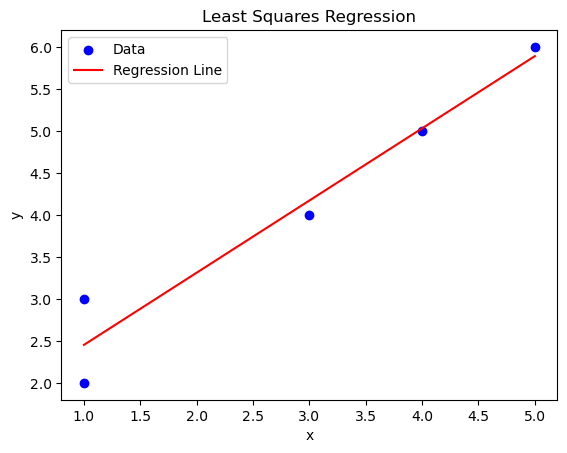

In [3]:
# Define the independent variable (x) and dependent variable (y) data
x = np.array([1, 1, 3, 4, 5])
y = np.array([2, 3, 4, 5, 6])
least_squares_regression_examples(x,y)

## More sythetic data with constant noise

Regression Line: y = 0.49 + 1.02x
R-squared: 0.51


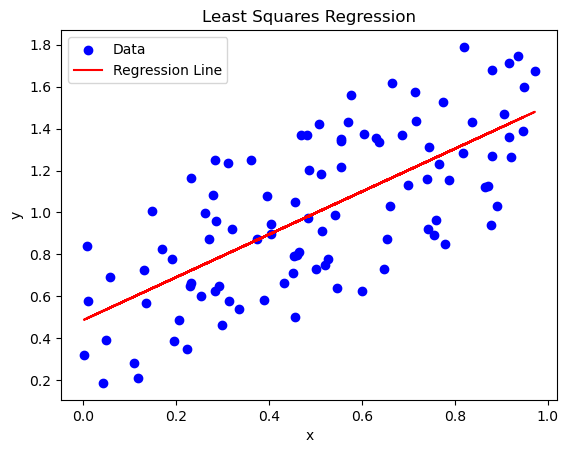

In [4]:
x = np.array([np.random.random() for i in range(100)])
y = np.array([np.random.random()+x[i] for i in range(100)])
least_squares_regression_examples(x,y)

## USGS regression equations


[https://pubs.usgs.gov/sir/2007/5204/](https://pubs.usgs.gov/sir/2007/5204/)  
USGS Scientific Investigations Report 2007-5204  
Magnitude and Frequency of Floods in Alabama, 2003  
By T.S. Hedgecock and Toby D. Feaster  
**"Regression relations were developed using generalized least-squares regression techniques to estimate flood magnitude and frequency on ungaged streams as a function of the basin drainage area."**  

![alabama regression equations](alabama.png "Alabama regression equations")  

[https://pubs.er.usgs.gov/publication/sir20125113](https://pubs.er.usgs.gov/publication/sir20125113)  
USGS Scientific Investigations Report 2012-5113  
Methods for determining magnitude and frequency of floods in California, based on data through water year 2006  
By Anthony J. Gotvald, Nancy A. Barth, Andrea G. Veilleux, and Charles Parrett  
**"Annual peak-flow data through water year 2006 were analyzed for 771 streamflow-gaging stations (streamgages) in California having 10 or more years of data. Flood-frequency estimates were computed for the streamgages by using the expected moments algorithm to fit a Pearson Type III distribution to logarithms of annual peak flows for each streamgage."**  

![california regression equations](california.png "California regression equations")  

## Now let's use some real data to build a general model that "works" across CONUS
We will use catchment attributes to try to predict return periods calculated with Log Pearson III from Bullitin 17b.  
[https://www.hydroshare.org/resource/c7739f47e2ca4a92989ec34b7a2e78dd/](https://www.hydroshare.org/resource/c7739f47e2ca4a92989ec34b7a2e78dd/)  
[https://hess.copernicus.org/articles/26/3377/2022/](https://hess.copernicus.org/articles/26/3377/2022/)

In [5]:
with open("camels_attributes.csv", "r") as f:
    df_attributes = pd.read_csv(f, index_col="gauge_id")
    
with open("camels_recurrence_intervals.csv", "r") as f:
    df_recurrence_intervals = pd.read_csv(f, index_col="gauge_id")

In [8]:
df_recurrence_intervals.head()

,ri_5,ri_10,ri_50,ri_500
gauge_id,,,,
1466500,19,23,43,82
10244950,33,42,81,163
10172800,57,82,121,202
9378630,32,75,163,401
13018300,112,153,202,292


### Random forest regression with cross validation
Scenarios to consider Random Forest Regression, which is widely used.
* Interactions and Nonlinear Effects. Learns complex interactions between features without explicitly specifying them in the model
* High-Dimensional Data.
* Robustness to Outliers.
* Handling Heterogeneous Data.

Here is a good, short, explaination of random forest: [https://towardsdatascience.com/a-limitation-of-random-forest-regression-db8ed7419e9f](https://towardsdatascience.com/a-limitation-of-random-forest-regression-db8ed7419e9f) 

In [6]:
def regress_recurrence(df_attributes, df_recurrence_intervals, target_ri_period, n_splits):
    """ Creates a regression model and analyzes it with Cross Validation
    
    Args:
        df_attributes (DataFrame): Catchment attributes that are used as model inputs
        df_recurrence_intervals (DataFrame): The target of our regression model
        target_ri_period (int): The specific recurrence interval we are trying to predict
        n_splits (int): The number of folds in the cross validation
    Returns
        RandomForestRegressor: A trained model that can be used to predict streamflow recurrence across CONUS
        
    """
    
    X=np.array(df_attributes)
    y=np.array(df_recurrence_intervals[f"ri_{target_ri_period}"])
    A=np.array(df_attributes['area_geospa_fabric'])
    # SET UP K-FOLD
    # Split into training groups
    kf = KFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(X)
    # evaluation metrics from the K-fold loop
    rmse_list = []
    r_sq_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        A_train, A_test = A[train_index], A[test_index]

        rf = RandomForestRegressor(n_estimators=100, random_state=42,
                                      criterion="absolute_error", min_samples_leaf=1,
                                      min_samples_split=2, max_depth=None,
                                      min_weight_fraction_leaf=0)

        rf.fit(X_train, y_train)

        y_hat = rf.predict(X_test) 

        rmse_list.append(np.sqrt(np.mean((y_test - y_hat)**2)))

        correlation_matrix = np.corrcoef(y_test, y_hat)
        correlation_xy = correlation_matrix[0,1]
        r_sq_list.append(correlation_xy**2)

        plt.scatter(y_test/A_test, y_hat/A_test, c="b")
        print('rmse: {:.2f}, r-squared: {:.2f}'.format(rmse_list[-1],r_sq_list[-1]))

    plt.plot([10,2000],[10,2000], 'k')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f"{target_ri_period}-year recurrence interval (area normalized)")
    plt.xlim([10,2000])
    plt.xscale('log')
    plt.ylim([10,2000])
    plt.yscale('log')
    plt.show()
    print('Mean values:')
    print(f'rmse: {np.mean(rmse_list):.2f}, r-squared: {np.mean(r_sq_list):.2f}')
    return rf

rmse: 7715.55, r-squared: 0.42
rmse: 14466.55, r-squared: 0.38
rmse: 9154.55, r-squared: 0.64
rmse: 7495.65, r-squared: 0.58
rmse: 8345.97, r-squared: 0.59
rmse: 5598.47, r-squared: 0.62
rmse: 6520.12, r-squared: 0.60
rmse: 6730.53, r-squared: 0.69
rmse: 6286.97, r-squared: 0.54
rmse: 7482.62, r-squared: 0.44


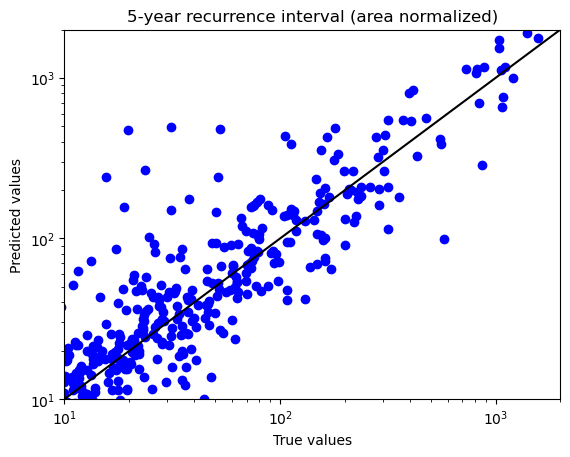

Mean values:
rmse: 7979.70, r-squared: 0.55


RandomForestRegressor(criterion='absolute_error', min_weight_fraction_leaf=0,
                      random_state=42)

In [9]:
regress_recurrence(df_attributes, df_recurrence_intervals, 5, 10)